In [1]:
import tensorflow as tf
import keras

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

### Dataset preparation for the classifiers

In [17]:
CLASS_NAMES = [
    "ADI",
    "BACK",
    "DEB",
    "LYM",
    "MUC",
    "MUS",
    "NORM",
    "STR",
    "TUM",
]

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../NCT-CRC-HE-small-5k-per-class",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.30,
    subset="both",
)

Found 45000 files belonging to 9 classes.
Using 31500 files for training.
Using 13500 files for validation.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../CRC-VAL-HE-7K",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

Found 7180 files belonging to 9 classes.


### Classifiers

https://keras.io/api/applications/

#### ResNet50

In [21]:
# create base model without fine-tuning the weights
base_model = keras.applications.ResNet50(
    weights=None, input_shape=(224, 224, 3), include_top=False
)

# add a global spatial average pooling layer
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = keras.layers.Dense(1024, activation="relu")(x)

# add a logistic layer
predictions = keras.layers.Dense(9, activation="softmax")(x)

# this is the model we will train
model_resnet50 = keras.models.Model(inputs=base_model.input, outputs=predictions)

# fine-tune the model
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='resnet50_model/checkpoint_{epoch:02d}.h5',
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        mode='auto',
        save_freq='epoch',
        options=None,
        initial_value_threshold=None
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    ),
]

# train the model
history_resnet50 = model_resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_list,
)

Epoch 1/25
985/985 [==============================] - 275s 274ms/step - loss: 0.9108 - accuracy: 0.6863 - auc: 0.9513 - precision: 0.7905 - recall: 0.5905 - val_loss: 3.3122 - val_accuracy: 0.3541 - val_auc: 0.7478 - val_precision: 0.3652 - val_recall: 0.3340
Epoch 2/25
985/985 [==============================] - 263s 267ms/step - loss: 0.4193 - accuracy: 0.8556 - auc: 0.9870 - precision: 0.8821 - recall: 0.8276 - val_loss: 4.2910 - val_accuracy: 0.3173 - val_auc: 0.7148 - val_precision: 0.3244 - val_recall: 0.3027
Epoch 3/25
985/985 [==============================] - 262s 266ms/step - loss: 0.2739 - accuracy: 0.9089 - auc: 0.9936 - precision: 0.9229 - recall: 0.8954 - val_loss: 3.9700 - val_accuracy: 0.2764 - val_auc: 0.6845 - val_precision: 0.2911 - val_recall: 0.2619
Epoch 4/25
985/985 [==============================] - 263s 267ms/step - loss: 0.2374 - accuracy: 0.9209 - auc: 0.9948 - precision: 0.9328 - recall: 0.9117 - val_loss: 2.8614 - val_accuracy: 0.3596 - val_auc: 0.7713 - val

In [9]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

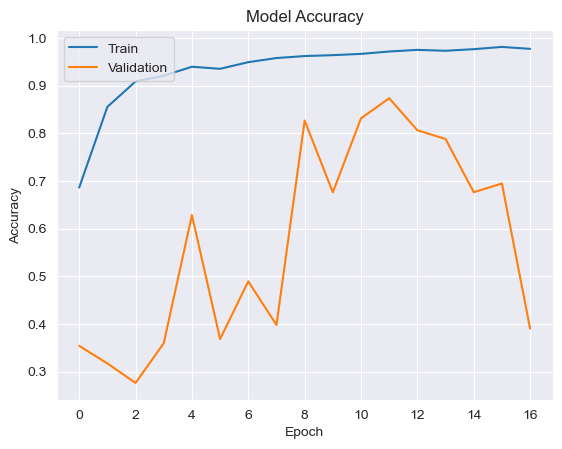

In [22]:
plt.plot(history_resnet50.history["accuracy"])
plt.plot(history_resnet50.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

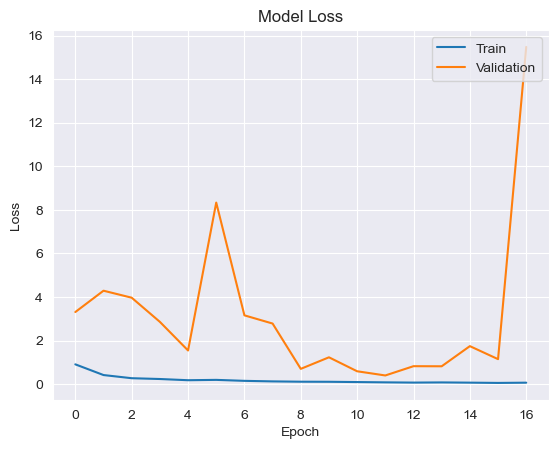

In [23]:
# display loss
plt.plot(history_resnet50.history["loss"])
plt.plot(history_resnet50.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [24]:
model_resnet50.evaluate(test_ds)

225/225 [==============================] - 18s 81ms/step - loss: 0.9197 - accuracy: 0.7462 - auc: 0.9550 - precision: 0.7543 - recall: 0.7366


[0.9197218418121338,
 0.7462395429611206,
 0.9550003409385681,
 0.7542783617973328,
 0.7366295456886292]

In [25]:
model_resnet50.evaluate(train_ds)

985/985 [==============================] - 77s 78ms/step - loss: 0.3513 - accuracy: 0.8828 - auc: 0.9894 - precision: 0.8935 - recall: 0.8756


[0.35134169459342957,
 0.8828253746032715,
 0.9893797636032104,
 0.8934598565101624,
 0.8756190538406372]

In [14]:
model_resnet50.save("../models/resnet_scratch_50_12.h5")